In [2]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns                                   # For pretty plot
from datetime import datetime, timedelta

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 50     

## Load ELL data

In [51]:
power = pd.read_csv('ELL data/power.csv', sep=';', parse_dates=['time'])
irrad = pd.read_csv('ELL data/irradiance.csv', sep=';', parse_dates=['time'])

In [52]:
power.head()

,time,power
0,2016-01-01 01:00:00,null
1,2016-01-01 01:01:00,null
2,2016-01-01 01:02:00,null
3,2016-01-01 01:03:00,null
4,2016-01-01 01:04:00,null


In [53]:
irrad.head()

,time,irradiance
0,2016-01-01 01:00:00,null
1,2016-01-01 01:01:00,null
2,2016-01-01 01:02:00,null
3,2016-01-01 01:03:00,null
4,2016-01-01 01:04:00,null


## Null values handling

In [68]:
whereis_null_power = power.copy()
whereis_null_power.loc[whereis_null_power.power != 'null', 'power'] = 0
whereis_null_power.loc[whereis_null_power.power == 'null', 'power'] = 1

In [69]:
whereis_null_power.head()

,time,power
0,2016-01-01 01:00:00,1
1,2016-01-01 01:01:00,1
2,2016-01-01 01:02:00,1
3,2016-01-01 01:03:00,1
4,2016-01-01 01:04:00,1


Plot 1 where power is null, 0 otherwise.

In [ ]:
# x = np.array(range(whereis_null_power.shape[0]))
# y = whereis_null_power.power
# str_xticks = whereis_null_power.time
# plt.xticks(x, str_xticks)
# plt.bar(x, y)
# plt.show()

Replace null values with zeros.

In [81]:
power.replace(to_replace='null', value=0, inplace=True)
irrad.replace(to_replace='null', value=0, inplace=True)

**TODO:** Are we sure we wanna set null values to 0s? This might affect our learning function. Why don't we just drop these rows.

## Add timestamp to each measurement

Convert measurement from string to float.

In [82]:
power['power'] = power['power'].astype(float)
irrad['irradiance'] = irrad['irradiance'].astype(float)

In [25]:
power.head()

,time,power
0,2016-01-01 01:00:00,0.0
1,2016-01-01 01:01:00,0.0
2,2016-01-01 01:02:00,0.0
3,2016-01-01 01:03:00,0.0
4,2016-01-01 01:04:00,0.0


Add timestamp to each measurement as difference in seconds from the first measurement.
**TODO:** correct me if I'm wrong

In [38]:
def get_timestamp_from_time(measurement_datetime, reference_datetime=datetime(2016, 1, 1, 1, 0, 0)):
    """
    Retrieve the difference in time between measurement_time and reference_time.
    :param measurement_datetime: pandas.tslib.Timestamp value of a measurement
    :param reference_datetime: reference datetime value (Default: 01/01/2016 1:00am)
    :return: difference in seconds between measurement_time and reference_time
    """
    
    return (measurement_datetime - reference_datetime) // timedelta(seconds=1)

In [39]:
# old
# seconds = power['time'].apply(lambda x: (datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ")  - datetime(2016, 1, 1, 1, 0, 0))  //timedelta(seconds=1))

In [83]:
seconds = power['time'].apply(get_timestamp_from_time)

In [84]:
power['timestamp'] = seconds
irrad['timestamp'] = seconds

In [42]:
power.head()

,time,power,timestamp
0,2016-01-01 01:00:00,0.0,0
1,2016-01-01 01:01:00,0.0,60
2,2016-01-01 01:02:00,0.0,120
3,2016-01-01 01:03:00,0.0,180
4,2016-01-01 01:04:00,0.0,240


## Number of panels doubled on May 24, 2016

**TODO:** Please, write some comments :P <br>
It took me a while before I remembered that this was the date the #panels doubled... ^^"

In [96]:
new_panels_date = datetime(2016,5,24,7,31,0)

In [93]:
ts_double_panels = get_timestamp_from_time(new_panels_date)

In [94]:
indx = power[power.timestamp >= ts_double_panels].index

Divide the power by 2 to take into account the doubled number of panels.

In [97]:
y = power.loc[power.timestamp >= ts_double_panels]['power'] / 2
y.head()

207751    0.0
207752    0.0
207753    0.0
207754    0.0
207755    0.0
Name: power, dtype: float64

In [99]:
power.ix[power.timestamp >= ts_double, 'power'] = y

In [100]:
power.loc[indx].tail()

,time,power,timestamp
274795,2016-07-09 20:55:00,0.0025,16487700
274796,2016-07-09 20:56:00,0.0025,16487760
274797,2016-07-09 20:57:00,0.0025,16487820
274798,2016-07-09 20:58:00,0.0025,16487880
274799,2016-07-09 20:59:00,0.0025,16487940


## Plot

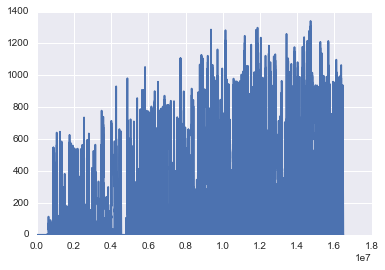

In [101]:
plt.plot(power['timestamp'], irrad['irradiance'])

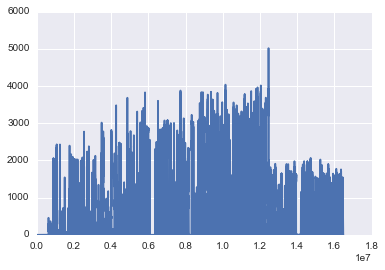

In [102]:
plt.plot(power['timestamp'], power['power'])

## Predict future values

Similar project:
http://cs229.stanford.edu/proj2014/Mayukh%20Samanta,Bharath%20Srikanth,Jayesh%20Yerrapragada,Short%20Term%20Power%20Forecasting%20Of%20Solar%20PV%20Systems%20Using%20Machine%20Learning%20Techniques.pdf

In [105]:
from sklearn import linear_model
# from sklearn.model_selection import cross_val_predict

In [106]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict

In [107]:
Pdc = power['power']
Gmi = irrad['irradiance']

In [111]:
lin_reg = linear_model.LinearRegression()

In [112]:
scores = cross_val_score(lin_reg, Gmi.reshape(-1,1), Pdc, cv=10)

In [113]:
print(scores.mean())

0.670966355699


In [118]:
lin_reg.fit(Gmi.reshape(-1,1), Pdc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
lin_reg.predict(0)

array([ 24.91935022])

In [120]:
lin_reg.predict(1)

array([ 27.5355655])

In [121]:
lin_reg.predict(1000)

array([ 2641.13462712])

In [116]:
predicted = cross_val_predict(lin_reg,Gmi.reshape(-1,1), Pdc, cv=10)

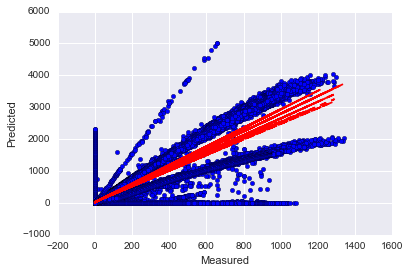

In [117]:
fig, ax = plt.subplots()
ax.scatter(Gmi, Pdc)
ax.plot(Gmi, predicted,'r--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()